# マルチインプットマルチアウトプットモデル

## 前提情報

Google Drive に以下のファイルがあること

* ラベル情報ファイル (2022/2/22 時点)
 * /data/20220222_sueki_label.csv

* 須恵器データファイル(voxelファイル、画像ファイル) (2022/2/8 時点)
 * /data/20220222_sueki_dataset.zip


## GPU情報確認

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar  4 05:26:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive をマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ラベル情報ファイルをコピー
!cp /content/drive/MyDrive/data/20220222_sueki_label.csv -d /content/

In [ ]:
# 須恵器データファイル(voxelファイル、画像ファイル)をコピー
!mkdir /content/data
!unzip /content/drive/MyDrive/data/20220222_sueki_dataset.zip -d /content/

In [ ]:
# Create output dir 
import datetime
now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9))) # 日本時刻

output_dir = './output_{}'.format(now.strftime('%Y%m%d%H%M%S'))

!mkdir $output_dir

### 必要パッケージのインポート

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import random

import os
import glob
import sys

### 3Dデータ読み込み

In [ ]:
df_label = pd.read_csv('/content/20220222_sueki_label.csv')

In [ ]:
class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
class_age = {0:'前葉',1:'中葉',2:'後葉'}


def get_keys_from_value(d, val):
    return str([k for k, v in d.items() if v == val][0])

for i in range(len(df_label)):
  df_label.loc[i,'class_type'] = get_keys_from_value(class_type, df_label.iloc[i,3])
  df_label.loc[i,'class_age'] = get_keys_from_value(class_age, df_label.iloc[i,4])

df_label

,Unnamed: 0,身・蓋,列品番号,型式,年代（6世紀）,向き,データセット,class_type,class_age
0,0,futa,J-6564,Ⅱ－３,中葉,1,train,2,1
1,1,futa,J-6568,Ⅱ－３,中葉,1,train,2,1
2,2,futa,J-6569,Ⅱ－５,後葉,1,train,4,2
3,3,futa,J-6570,Ⅱ－４,後葉,1,valid,3,2
4,4,futa,J-6572,Ⅱ－３,中葉,1,valid,2,1
...,...,...,...,...,...,...,...,...,...
103,103,mi,J-3650,Ⅱ－５,後葉,0,train,4,2
104,104,mi,J-11536,Ⅱ－５,後葉,0,train,4,2
105,105,mi,J-22896-19,Ⅱ－５,後葉,0,train,4,2
106,106,mi,J-22896-21,Ⅱ－５,後葉,0,train,4,2


In [ ]:
def coordinates3d_to_matrix(points, points_rgba, matrix_size=32):
    mx = my = mz = matrix_size
    
    ax_min = points.min(axis=0)
    ax_max = points.max(axis=0)
    # matrixの-1以内に全ての点を収める
    points = points - (ax_max - ax_min).max() / 2 - ax_min + (ax_max-ax_min).max()/2.0-(ax_max-ax_min)/2.0
    cells = np.array([mx-2, my-2, mz-2])
    size = (ax_max - ax_min).max() / cells
    size = np.where(size == 0, sys.float_info.epsilon, size)
    points /= size
    points = points + cells / 2.0
    points = np.rint(points).astype(np.uint32)
    
    matrix = np.zeros([mx, my, mz, 4])
    count = np.ones([mx, my, mz, 1])
    for n in range(len(points)):
        matrix[points[n,0],points[n,1],points[n,2],0:4] += points_rgba[n,0:4]
        count[points[n,0],points[n,1],points[n,2],0] += 1

    matrix /= count
    matrix = np.rint(matrix).astype(np.uint32)
    return matrix
 
# https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/api.html
def plot_rgba(matrix, matrix_size=32, points_size=15):

    X , Y , Z = [], [], []
    for z in range(matrix_size):
        for y in range(matrix_size):
            for x in range(matrix_size):
                Y.append(x)
                Z.append(y)
                X.append(z)

    fig = plt.figure(figsize=(10, 10))
#    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', aspect='auto')

    colors = np.reshape(matrix, (matrix_size**3, 4))
    
    sc = ax.scatter(X, Y, Z, c=colors/255.0, s=points_size, marker="s")
    ax.set_title("3D - voxel({},{},{},4)".format(matrix_size, matrix_size, matrix_size))
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
#    ax.set_axis_off()   
    plt.show()


def plot_voxel(matrix, matrix_size=32, points_size=15):

    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d', aspect='auto')

    facecolors = matrix.transpose(2,0,1,3)
#    facecolors = explode(matrix)
    facecolors = facecolors / 255
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
#    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

#    ax.voxels(x, y, z, filled, edgecolors='gray', facecolors=facecolors, shade=False)
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    ax.set_title("3D - voxel({},{},{},4)".format(matrix_size, matrix_size, matrix_size))
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
#    ax.set_axis_off()   
    plt.show()


## 学習（クラス分類）

### データ読み込み

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB4

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import random

import os
import glob
import sys

In [ ]:
# 証明書更新(MacOS ver11以降で必須)
#    https://qiita.com/legion98/items/5817c1ee7461cbb204e0
#    以下をターミナルで実行
#    /Applications/Python\ 3.8/Install\ Certificates.command

In [ ]:
class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
class_age = {0:'前葉',1:'中葉',2:'後葉'}

num_class_type = len(class_type)
num_class_age = len(class_age)


MT_SIZE = 64
IM_WIDTH = IM_HEIGHT = 380

#EfficientNetB0 – (224, 224, 3)
#EfficientNetB1 – (240, 240, 3)
#EfficientNetB2 – (260, 260, 3)
#EfficientNetB3 – (300, 300, 3)
#EfficientNetB4 – (380, 380, 3)
#EfficientNetB5 – (456, 456, 3)
#EfficientNetB6 – (528, 528, 3)
#EfficientNetB7 – (600, 600, 3)

In [ ]:
###### ファイル名から正解ラベルを取り出す関数
def parse_filepath(filepath):
    # ラベル(str)、ボクセルサイズ(int)、番号(int) を返す
    try:
        path, filename = os.path.split(filepath)  # 相対パスからファイル名を取り出す
        filename, ext = os.path.splitext(filename)  # 拡張子を除く
        mifuta, name, label_type, label_age, size, angle = filename.split("_")
        return mifuta, name, int(label_type), int(label_age), int(size), int(angle) 


#        size, mifuta, name, label_type, label_age, num = filename.split("_")
#        return int(size), mifuta, name, int(label_type), int(label_age), int(num) 

    except Exception as e:  # いくつか欠損値があるので例外処理をしておく
        print(filepath)
        return None, None, None, None, None, None

voxels = []
#for data_name in classes:
DATA_DIR = './data/voxel'
files = glob.glob(os.path.join(DATA_DIR, "*.npy")) 
files.sort()

attributes = list(map(parse_filepath, files))  # 上で作成した関数にファイル名を一つずつ入力
#attributes
#voxels
#classes

In [ ]:
df = pd.DataFrame(attributes)
df['voxel_path'] = files

df.columns = ['mifuta', 'name', 'label_type', 'label_age', 'voxel_size', 'angle', 'voxel_path']

images_top, images_side, images_bottom = [], [], []
dataset = []
for i in range(len(df)):
  
    images_top.append('./data/image/{}_{}_{}_{}_top_{:0=3}.png'.format(df.loc[i, 'mifuta'], df.loc[i, 'name'], df.loc[i, 'label_type'], df.loc[i, 'label_age'], df.loc[i, 'angle']))
    images_side.append('./data/image/{}_{}_{}_{}_side_{:0=3}.png'.format(df.loc[i, 'mifuta'], df.loc[i, 'name'], df.loc[i, 'label_type'], df.loc[i, 'label_age'], df.loc[i, 'angle']))
    images_bottom.append('./data/image/{}_{}_{}_{}_bottom_{:0=3}.png'.format(df.loc[i, 'mifuta'], df.loc[i, 'name'], df.loc[i, 'label_type'], df.loc[i, 'label_age'], df.loc[i, 'angle']))
#    print(df.loc[i, 'name'])
#    '{}'.format(df_label[df_label['列品番号'] == df.loc[i, 'name']]['データセット'])

    dataset.append('{}'.format(df_label[df_label['列品番号'] == df.loc[i, 'name']]['データセット'].iloc[-1]))


df['image_top_path'] = images_top
df['image_side_path'] = images_side
df['image_bottom_path'] = images_bottom
df['dataset'] = dataset

df.columns = ['mifuta', 'name', 'label_type', 'label_age', 'voxel_size', 'angle', 'voxel_path', 'image_top_path', 'image_side_path', 'image_bottom_path','dataset']







data_num = 12

train_idx =[]
valid_idx =[]
test_idx =[]

for i in range(len(df)):

  if df.loc[i,'dataset'] == 'train':
    train_idx.extend([i])
  elif df.loc[i,'dataset'] == 'valid':
    valid_idx.extend([i])
  elif df.loc[i,'dataset'] == 'test':
#    if i % 3 == 0:
    test_idx.extend([i])


#train_idx = list(range(0, int(data_num * 0.7)))
#train_idx.extend(list(range(data_num, data_num + int(data_num * 0.7))))
#train_idx.extend(list(range(data_num*2, data_num*2 + int(data_num * 0.7))))

#valid_idx = list(range(int(data_num * 0.7), int(data_num * 0.9)))
#valid_idx.extend(list(range(data_num + int(data_num * 0.7), data_num + int(data_num * 0.9))))
#valid_idx.extend(list(range(data_num*2 + int(data_num * 0.7), data_num*2 + int(data_num * 0.9))))

#test_idx = list(range(int(data_num * 0.9), data_num))
#test_idx.extend(list(range(data_num + int(data_num * 0.9), data_num*2)))
#test_idx.extend(list(range(data_num*2 + int(data_num * 0.9), data_num*3)))

random.shuffle(train_idx)
#random.shuffle(valid_idx)
#random.shuffle(test_idx)
df

,mifuta,name,label_type,label_age,voxel_size,angle,voxel_path,image_top_path,image_side_path,image_bottom_path,dataset
0,futa,J-11536,4,2,64,0,./data/voxel/futa_J-11536_4_2_64_000.npy,./data/image/futa_J-11536_4_2_top_000.png,./data/image/futa_J-11536_4_2_side_000.png,./data/image/futa_J-11536_4_2_bottom_000.png,train
1,futa,J-11536,4,2,64,30,./data/voxel/futa_J-11536_4_2_64_030.npy,./data/image/futa_J-11536_4_2_top_030.png,./data/image/futa_J-11536_4_2_side_030.png,./data/image/futa_J-11536_4_2_bottom_030.png,train
2,futa,J-11536,4,2,64,60,./data/voxel/futa_J-11536_4_2_64_060.npy,./data/image/futa_J-11536_4_2_top_060.png,./data/image/futa_J-11536_4_2_side_060.png,./data/image/futa_J-11536_4_2_bottom_060.png,train
3,futa,J-11536,4,2,64,90,./data/voxel/futa_J-11536_4_2_64_090.npy,./data/image/futa_J-11536_4_2_top_090.png,./data/image/futa_J-11536_4_2_side_090.png,./data/image/futa_J-11536_4_2_bottom_090.png,train
4,futa,J-11536,4,2,64,120,./data/voxel/futa_J-11536_4_2_64_120.npy,./data/image/futa_J-11536_4_2_top_120.png,./data/image/futa_J-11536_4_2_side_120.png,./data/image/futa_J-11536_4_2_bottom_120.png,train
...,...,...,...,...,...,...,...,...,...,...,...
1291,mi,J-9830,4,2,64,210,./data/voxel/mi_J-9830_4_2_64_210.npy,./data/image/mi_J-9830_4_2_top_210.png,./data/image/mi_J-9830_4_2_side_210.png,./data/image/mi_J-9830_4_2_bottom_210.png,train
1292,mi,J-9830,4,2,64,240,./data/voxel/mi_J-9830_4_2_64_240.npy,./data/image/mi_J-9830_4_2_top_240.png,./data/image/mi_J-9830_4_2_side_240.png,./data/image/mi_J-9830_4_2_bottom_240.png,train
1293,mi,J-9830,4,2,64,270,./data/voxel/mi_J-9830_4_2_64_270.npy,./data/image/mi_J-9830_4_2_top_270.png,./data/image/mi_J-9830_4_2_side_270.png,./data/image/mi_J-9830_4_2_bottom_270.png,train
1294,mi,J-9830,4,2,64,300,./data/voxel/mi_J-9830_4_2_64_300.npy,./data/image/mi_J-9830_4_2_top_300.png,./data/image/mi_J-9830_4_2_side_300.png,./data/image/mi_J-9830_4_2_bottom_300.png,train


In [ ]:
print(train_idx)
print(valid_idx)
print(test_idx)

[20, 76, 1194, 484, 79, 1176, 344, 921, 140, 907, 377, 918, 570, 1023, 1113, 764, 252, 1199, 1193, 548, 697, 678, 122, 597, 112, 375, 599, 153, 495, 925, 626, 1109, 23, 1242, 149, 726, 376, 77, 219, 1068, 382, 688, 1245, 633, 774, 1002, 230, 702, 1138, 1182, 473, 1287, 889, 1136, 1198, 360, 608, 722, 808, 368, 1222, 912, 684, 1022, 831, 798, 258, 574, 1072, 346, 148, 721, 47, 238, 1241, 914, 82, 0, 262, 634, 1059, 1217, 778, 1067, 120, 502, 1026, 155, 2, 546, 233, 247, 572, 1107, 235, 1025, 12, 145, 1289, 1219, 1083, 679, 353, 810, 154, 605, 1191, 349, 996, 75, 1128, 913, 246, 1223, 916, 380, 804, 5, 692, 369, 1108, 1066, 933, 690, 900, 803, 339, 1213, 1240, 81, 598, 18, 1284, 1058, 1063, 475, 366, 137, 999, 260, 350, 972, 354, 381, 1221, 901, 541, 838, 935, 1180, 1090, 1218, 924, 44, 829, 1080, 345, 314, 497, 1003, 775, 488, 1106, 131, 1115, 566, 217, 39, 243, 3, 811, 1110, 674, 890, 116, 763, 812, 1216, 571, 1030, 129, 902, 611, 1088, 478, 320, 799, 693, 471, 1082, 801, 1247, 1244, 1

In [ ]:
# データ拡張
# https://axa.biopapyrus.jp/deep-learning/sample/augmentation.html

import numpy as np
import skimage

def augmentation_rotation(img):
    r = np.random.rand(1)

    if r > 0.50:
        random_degree = random.uniform(0, 90)
        img = skimage.transform.rotate(img, random_degree, resize=True, cval=0)

    return img


def augmentation_flip(img, vertical=True, horizontal=True):

    if vertical:
        if np.random.rand(1) > 0.5:
            img = img[::-1, :, :] # 上下反転

    if horizontal:
        if np.random.rand(1) > 0.5:
            img = img[:, ::-1, :] # 左右反転

    return img

def augmentation_noise(img):
    r = np.random.rand(1)

    if r < 1/7:
        img = skimage.util.random_noise(img, mode='localvar') # ホワイト ガウス ノイズ
    elif r < 2/7:
        img = skimage.util.random_noise(img, mode='salt')
    elif r < 3/7:
        img = skimage.util.random_noise(img, mode='s&p')
    elif r < 4/7:
        img = skimage.util.random_noise(img, mode='speckle', var=0.01)
    elif r < 5/7:
        img = skimage.util.random_noise(img, mode='poisson')
    elif r < 6/7:
        img = skimage.util.random_noise(img, mode='gaussian', var=0.01)

    if r < 6/7:
        img = img * 255

#    img = img.astype(np.uint8)

    return img

In [ ]:
from PIL import Image

class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
class_age = {0:'前葉',1:'中葉',2:'後葉'}

class_type_shift = {0:0,1:1,2:2,3:3,4:4}
class_age_shift = {0:0,1:1,2:2}

#class_type_shift = {2:0,3:1,4:2}
#class_age_shift = {1:0,2:1}

#num_to_class_type = {0:'Ⅱ－３',1:'Ⅱ－４',2:'Ⅱ－５'}
#num_to_class_age = {0:'中葉',1:'後葉'}

num_to_class_type = {0:'Ⅱ－１',1:'Ⅱ－２',2:'Ⅱ－３',3:'Ⅱ－４',4:'Ⅱ－５'}
num_to_class_age = {0:'前葉',1:'中葉',2:'後葉'}


# generator 作成
def get_data_generator(df, indices, for_training, data_augmentation=False,  batch_size=32):
    # 3D Voxel、 top 画像、 side 画像、 bottom 画像、 を batch_sizeずつ返す

#    images_top, images_side, images_bottom, labels = [], [], [], []

    voxels, images_top, images_side, images_bottom, labels1, labels2 = [], [], [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            voxel, top, side, bottom, label_type, label_age = r['voxel_path'], r['image_top_path'], r['image_side_path'], r['image_bottom_path'], r['label_type'], r['label_age']
                        
            voxels.append(np.load(voxel, allow_pickle=True))

            im1 = Image.open(top)
            im1 = im1.resize((IM_WIDTH, IM_HEIGHT))
            if data_augmentation:
                im1 = augmentation_flip(np.array(im1), vertical=False, horizontal=True)
                im1 = augmentation_noise(np.array(im1))
            im1 = np.array(im1) / 255.0
            im1 = im1[:,:,:3] # Delete Alpha Channel
            images_top.append(im1)

            im2 = Image.open(side)
            im2 = im2.resize((IM_WIDTH, IM_HEIGHT))
            if data_augmentation:
                im2 = augmentation_flip(np.array(im2), vertical=False, horizontal=True)
                im2 = augmentation_noise(np.array(im2))
            im2 = np.array(im2) / 255.0
            im2 = im2[:,:,:3] # Delete Alpha Channel
            images_side.append(im2)

            im3 = Image.open(bottom)
            im3 = im3.resize((IM_WIDTH, IM_HEIGHT))
            if data_augmentation:
                im3 = augmentation_flip(np.array(im3), vertical=False, horizontal=True)
                im3 = augmentation_noise(np.array(im3))
            im3 = np.array(im3) / 255.0
            im3 = im3[:,:,:3] # Delete Alpha Channel
            images_bottom.append(im3)

            labels1.append(to_categorical(class_type_shift[label_type], 5))
            labels2.append(to_categorical(class_age_shift[label_age], 3))

            if len(voxels) >= batch_size:  # メモリを考慮して少しずつ結果を返す
                yield [np.array(images_top), np.array(images_side), np.array(images_bottom), np.array(voxels)], [np.array(labels1), np.array(labels2)]
#                yield [np.asarray(voxels), np.array(images_top), np.array(images_side), np.array(images_bottom)], [np.array(labels)]
                #images_top, images_side, images_bottom, labels = [], [], [], []
                voxels, images_top, images_side, images_bottom, labels1, labels2 = [], [], [], [], [], []

        if not for_training:
            break

### モデル構築

In [ ]:
###### モデルの作成
input_layer1 = Input(shape=(IM_HEIGHT, IM_WIDTH, 3), name='input_layer1')
input_layer2 = Input(shape=(IM_HEIGHT, IM_WIDTH, 3), name='input_layer2') 
input_layer3 = Input(shape=(IM_HEIGHT, IM_WIDTH, 3), name='input_layer3') 
input_layer4 = Input(shape=(MT_SIZE, MT_SIZE, MT_SIZE,  4), name='input_layer4')

efficient_net1 = EfficientNetB4(
    weights= 'imagenet' ,#'noisy-student' or 'imagenet' 
    include_top=False,  # 全結合層は自分で作成するので要らない
    input_tensor = input_layer1,  # 入力
    pooling='max')

for layer in efficient_net1.layers:
    layer.trainable = False
    # 複数のEfficientNetを一つのモデルで利用するときにレイヤーの名前が重複する問題を回避
    # name属性はread-onlyになっている。_nameというアンダーバー付きの隠し属性を設定して回避する。
    layer._name = layer.name + str("_1")

efficient_net2 = EfficientNetB4(
    weights= 'imagenet' ,
    include_top=False,
    input_tensor = input_layer2,
    pooling='max')

for layer in efficient_net2.layers:
    layer.trainable = False
    layer._name = layer.name + str("_2")

efficient_net3 = EfficientNetB4(
    weights= 'imagenet' ,
    include_top=False,
    input_tensor = input_layer3,
    pooling='max')

for layer in efficient_net3.layers:
    layer.trainable = False
    layer._name = layer.name + str("_3")

    
conv3d_layer1 =Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer1')(input_layer4)
conv3d_layer2 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer2')(conv3d_layer1)
maxpooling_layer1 = MaxPooling3D(name='maxpooling_layer1')(conv3d_layer2)
batchnormalization_layer1 = BatchNormalization(name='batchnormalization_layer1')(maxpooling_layer1)

conv3d_layer3 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer3')(batchnormalization_layer1)
conv3d_layer4 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer4')(conv3d_layer3)
maxpooling_layer2 = MaxPooling3D(name='maxpooling_layer2')(conv3d_layer4)
batchnormalization_layer2 = BatchNormalization(name='batchnormalization_layer2')(maxpooling_layer2)

conv3d_layer5 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer5')(batchnormalization_layer2)
conv3d_layer6 = Conv3D(64, (3,3,3), strides=(1, 1, 1), activation='relu', name='conv3d_layer6')(conv3d_layer5)
maxpooling_layer3 = MaxPooling3D(name='maxpooling_layer3')(conv3d_layer6)
batchnormalization_layer3 = BatchNormalization(name='batchnormalization_layer3')(maxpooling_layer3)


#globalaveragepooling_layer1 = GlobalAveragePooling3D(name='globalaveragepooling_layer1')(maxpooling_layer1)

flatten_layer1 = Flatten(name='flatten_layer1')(batchnormalization_layer3)


# shape 確認
print('efficient_net1.output.shape : {}'.format(efficient_net1.output.shape))
print('efficient_net2.output.shape : {}'.format(efficient_net2.output.shape))
print('efficient_net3.output.shape : {}'.format(efficient_net3.output.shape))
print('flatten_layer1.shape : {}'.format(flatten_layer1.shape))

# 結合
concatted = Concatenate()([efficient_net1.output, efficient_net2.output, efficient_net3.output, flatten_layer1])
#concatted = Concatenate([efficient_net1.output, efficient_net2.output, efficient_net3.output, age_output], axis=1)

# shape 確認
print('concatted.shape : {}'.format(concatted.shape))

dense_layer2 = Dense(units=128, activation='relu', name='dense_layer2')(concatted)
dropout_layer1 = Dropout(rate=0.5, name='dropout_layer1')(dense_layer2)
dense_layer3 = Dense(units=128, activation='relu', name='dense_layer3')(dropout_layer1)
dropout_layer2 = Dropout(rate=0.5, name='dropout_layer2')(dense_layer3)

# 複数出力にする必要があるので、concattedの層から全結合層を枝分かれさせる

#_ = Dense(units=128, activation='relu')(concatted)
#output = Dense(units=1, activation='sigmoid', name='output')(_)


output1 = Dense(units=len(class_type_shift), activation='softmax', name='output1')(dropout_layer2)
output2 = Dense(units=len(class_age_shift), activation='softmax', name='output2')(dropout_layer2)


model = Model(inputs=[input_layer1, input_layer2, input_layer3, input_layer4], outputs=[output1, output2])


# 最適化手法・損失関数・評価関数を定義してコンパイル
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              loss_weights={'output1': 1,'output2': 1},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

#model.compile(optimizer="rmsprop", 
#              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
#              loss_weights={'output1': 1,'output2': 1},
#              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

71696384/71686520 [==============================] - 1s 0us/step
efficient_net1.output.shape : (None, 1792)
efficient_net2.output.shape : (None, 1792)
efficient_net3.output.shape : (None, 1792)
flatten_layer1.shape : (None, 4096)
concatted.shape : (None, 9472)


In [ ]:
model.summary()

with open('{}/model_summary.txt'.format(output_dir), "w") as fp:
    model.summary(print_fn=lambda x: fp.write(x + "\r\n"))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer1_1 (InputLayer)    [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_layer2_2 (InputLayer)    [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_layer3_3 (InputLayer)    [(None, 380, 380, 3  0           []                               
                                )]                                                            

In [ ]:
modelimage_file_path = '{}/model.png'.format(output_dir)
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, to_file=modelimage_file_path, show_shapes=True, show_layer_names=False )

### 学習

In [ ]:
# バッチサイズを定義
batch_size = 32
valid_batch_size = 32

epochs = 150

train_gen = get_data_generator(df, train_idx, for_training=True, data_augmentation=False, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, data_augmentation=False, batch_size=valid_batch_size)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))
#model_checkpoint = ModelCheckpoint('mimo_{}.hdf5'.format(matrix_size), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
#callbacks=[csv_logger,model_checkpoint,early_stopping]
callbacks=[csv_logger]


history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

# モデル保存
model_file_path = '{}/MIMO_model.h5'.format(output_dir)
model.save(model_file_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/150
20/20 [==============================] - 122s 4s/step - loss: 12.2070 - output1_loss: 7.1133 - output2_loss: 5.0937 - output1_accuracy: 0.1656 - output2_accuracy: 0.3438 - val_loss: 2.9596 - val_output1_loss: 1.8141 - val_output2_loss: 1.1456 - val_output1_accuracy: 0.1094 - val_output2_accuracy: 0.5281
Epoch 2/150
20/20 [==============================] - 68s 3s/step - loss: 5.6495 - output1_loss: 3.2743 - output2_loss: 2.3752 - output1_accuracy: 0.2188 - output2_accuracy: 0.3828 - val_loss: 2.6319 - val_output1_loss: 1.5964 - val_output2_loss: 1.0356 - val_output1_accuracy: 0.2500 - val_output2_accuracy: 0.4969
Epoch 3/150
20/20 [==============================] - 68s 3s/step - loss: 3.6276 - output1_loss: 2.1748 - output2_loss: 1.4528 - output1_accuracy: 0.2422 - output2_accuracy: 0.4031 - val_loss: 2.5481 - val_output1_loss: 1.5922 - val_output2_loss: 0.9560 - val_output1_accuracy: 0.2688 - val_output2_accuracy: 0.5625
Epoch 4/150
20/20 [==============================] - 

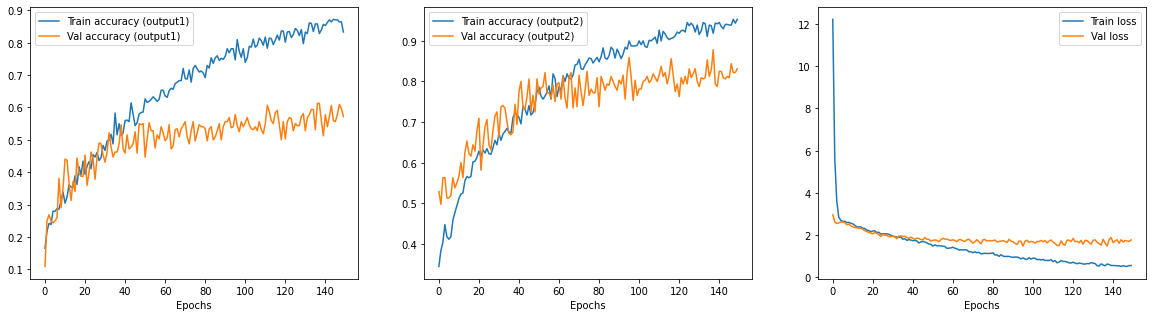

In [ ]:
history_path = '{}/history.png'.format(output_dir)
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['output1_accuracy'], label='Train accuracy (output1)')
    axes[0].plot(history.history['val_output1_accuracy'], label='Val accuracy (output1)')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['output2_accuracy'], label='Train accuracy (output2)')
    axes[1].plot(history.history['val_output2_accuracy'], label='Val accuracy (output2)')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['loss'], label='Train loss')
    axes[2].plot(history.history['val_loss'], label='Val loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    plt.savefig(history_path)

plot_train_history(history)

### テストデータセットで精度検証

In [ ]:
!unzip /content/drive/MyDrive/model/output_20220224235049.zip -d /content/

Archive:  /content/drive/MyDrive/model/output_20220224235049.zip
   creating: /content/output_20220224235049/
  inflating: /content/output_20220224235049/confusion_matrix_型式.png  
  inflating: /content/output_20220224235049/history.png  
  inflating: /content/output_20220224235049/model_summary.txt  
  inflating: /content/output_20220224235049/MIMO_model.h5  
  inflating: /content/output_20220224235049/confusion_matrix_年代.png  
  inflating: /content/output_20220224235049/training.log  
   creating: /content/output_20220224235049/image/
  inflating: /content/output_20220224235049/image/image_80_OK_pred1_2_label1_2_pred2_1_label2_1.png  
  inflating: /content/output_20220224235049/image/image_29_OK_pred1_2_label1_2_pred2_1_label2_1.png  
  inflating: /content/output_20220224235049/image/image_62_OK_pred1_4_label1_4_pred2_2_label2_2.png  
  inflating: /content/output_20220224235049/image/image_73_OK_pred1_2_label1_2_pred2_1_label2_1.png  
  inflating: /content/output_20220224235049/image/

In [ ]:
from keras.models import load_model

model_name = '/content/output_20220224235049/MIMO_model.h5'
#model_name = "{}/MIMO_model.h5".format(output_dir)


model = load_model(model_name)

test_batch_size = len(test_idx)

print(test_batch_size)

test_gen = get_data_generator(df, test_idx, for_training=True, data_augmentation=False, batch_size=test_batch_size)


#test_evaluate = model.evaluate_generator(test_gen, verbose=1, steps=len(test_idx)//test_batch_size)
#print(test_evaluate)


312


### テストデータ詳細確認用

In [ ]:
#from keras.models import load_model

#num_to_classes = {0:"J-9776", 1:"J-22826", 2:"J-22896-18"}
#model_name = './cnn_3d_{}.hdf5'.format(matrix_size)
#model = load_model(model_name)

x_test, y_test = next(test_gen)

predict = model.predict(x_test)


predict_label = [np.argmax(predict[0], axis=1), np.argmax(predict[1], axis=1)]
y_test_print = [np.argmax(y_test[0], axis=1), np.argmax(y_test[1], axis=1)]

#print(predict_label)

#print(predict_label[0][x])



In [ ]:
# df.columns = ['mifuta', 'name', 'label_type', 'label_age', 'voxel_size', 'angle', 'voxel_path', 'image_top_path', 'image_side_path', 'image_bottom_path','dataset']

print("{},{},{},{},{},{},{},{}".format('', '蓋・身', '列品番号', '回転角度', '正解ラベル-型式', '正解ラベル-時代', '推論ラベル-型式', '推論ラベル-時代'))

np.set_printoptions(formatter={'float': '{:.4e}'.format})
for x in range(len(y_test[0])):
    i = test_idx[x]
    r = df.iloc[i]
    print("{},{},{},{:03}，{},{},{},{}".format(x, r['mifuta'], r['name'], r['angle'], num_to_class_type[r['label_type']], num_to_class_age[r['label_age']], num_to_class_type[predict_label[0][x]], num_to_class_age[predict_label[1][x]]))
#    print("{}　predict1:{}，predict type:{}，true type:{}".format(test_idx[x],predict[0][x,:],num_to_class_type[predict_label[0][x]],num_to_class_type[y_test_print[0][x]]))

#    print("{}　predict1:{}，predict type:{}，true type:{}".format(test_idx[x],predict[0][x,:],num_to_class_type[predict_label[0][x]],num_to_class_type[y_test_print[0][x]]))
#    print("{}　predict2:{}，predict age:{}，true age:{}".format(test_idx[x],predict[1][x,:],num_to_class_age[predict_label[1][x]],num_to_class_age[y_test_print[1][x]]))


,蓋・身,列品番号,回転角度,正解ラベル-型式,正解ラベル-時代,推論ラベル-型式,推論ラベル-時代
0,futa,J-13305-4,000，Ⅱ－３,中葉,Ⅱ－３,後葉
1,futa,J-13305-4,030，Ⅱ－３,中葉,Ⅱ－３,中葉
2,futa,J-13305-4,060，Ⅱ－３,中葉,Ⅱ－３,中葉
3,futa,J-13305-4,090，Ⅱ－３,中葉,Ⅱ－３,中葉
4,futa,J-13305-4,120，Ⅱ－３,中葉,Ⅱ－５,後葉
5,futa,J-13305-4,150，Ⅱ－３,中葉,Ⅱ－３,中葉
6,futa,J-13305-4,180，Ⅱ－３,中葉,Ⅱ－３,中葉
7,futa,J-13305-4,210，Ⅱ－３,中葉,Ⅱ－３,中葉
8,futa,J-13305-4,240，Ⅱ－３,中葉,Ⅱ－３,後葉
9,futa,J-13305-4,270，Ⅱ－３,中葉,Ⅱ－３,中葉
10,futa,J-13305-4,300，Ⅱ－３,中葉,Ⅱ－３,中葉
11,futa,J-13305-4,330，Ⅱ－３,中葉,Ⅱ－３,中葉
12,futa,J-134,000，Ⅱ－３,中葉,Ⅱ－５,後葉
13,futa,J-134,030，Ⅱ－３,中葉,Ⅱ－５,後葉
14,futa,J-134,060，Ⅱ－３,中葉,Ⅱ－５,後葉
15,futa,J-134,090，Ⅱ－３,中葉,Ⅱ－４,後葉
16,futa,J-134,120，Ⅱ－３,中葉,Ⅱ－５,後葉
17,futa,J-134,150，Ⅱ－３,中葉,Ⅱ－５,後葉
18,futa,J-134,180，Ⅱ－３,中葉,Ⅱ－３,後葉
19,futa,J-134,210，Ⅱ－３,中葉,Ⅱ－５,後葉
20,futa,J-134,240，Ⅱ－３,中葉,Ⅱ－５,後葉
21,futa,J-134,270，Ⅱ－３,中葉,Ⅱ－３,後葉
22,futa,J-134,300，Ⅱ－３,中葉,Ⅱ－４,後葉
23,futa,J-134,330，Ⅱ－３,中葉,Ⅱ－４,後葉
24,futa,J-20297,000，Ⅱ－１,前葉,Ⅱ－３,中葉
25,futa,J-20297,030，Ⅱ－１,前葉,Ⅱ－５,後葉
26,futa,J-20297,060，Ⅱ－１,前葉,Ⅱ－５,後葉
27,futa,J-20297,090，Ⅱ－１,前葉,Ⅱ－３,後葉
28,futa

In [ ]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 4.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=218e1cf0afc72ea2628d3c0e4c0b136d7d39bdbf6428eeb83b8d5b3b9aff2be7
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4
 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3
 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 4 2 2 2 2 2 2 2 4 4 4 3 4 4 2 4 4 2 3 3 2 4 4 2 4 4 4 4 2 4 4 2 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 2 4 4 2 4 4 2 4 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 1
 1 0 1 0 0 1 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

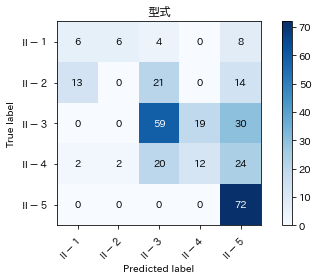

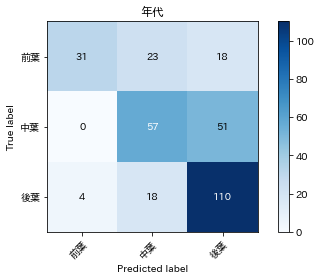

In [ ]:
# 混同行列で見てみる
from sklearn.metrics import confusion_matrix

# おまけ
# 混同行列をもっと見やすく (参考: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    confusion_matrix_path = '{}/confusion_matrix_{}'.format(output_dir, title)
    plt.savefig(confusion_matrix_path)
    return ax

print(y_test_print[0])
print(predict_label[0])


print(num_to_class_type)
print(num_to_class_age)

plot_confusion_matrix(y_test_print[0], predict_label[0], '型式' ,classes=num_to_class_type.values())
plot_confusion_matrix(y_test_print[1], predict_label[1], '年代' ,classes=num_to_class_age.values())


In [ ]:
from sklearn.metrics import classification_report

cr_type = classification_report(y_test_print[0], predict_label[0], target_names=num_to_class_type.values(), output_dict=True)
df_type = pd.DataFrame(cr_type)
df_type.transpose()
#plot_confusion_matrix(y_test_print[0], predict_label[0], '型式' ,classes=num_to_class_type.values())
#plot_confusion_matrix(y_test_print[1], predict_label[1], '年代' ,classes=num_to_class_age.values())



,precision,recall,f1-score,support
Ⅱ－１,0.285714,0.250000,0.266667,24.000000
Ⅱ－２,0.000000,0.000000,0.000000,48.000000
Ⅱ－３,0.567308,0.546296,0.556604,108.000000
Ⅱ－４,0.387097,0.200000,0.263736,60.000000
Ⅱ－５,0.486486,1.000000,0.654545,72.000000
accuracy,0.477564,0.477564,0.477564,0.477564
macro avg,0.345321,0.399259,0.348310,312.000000
weighted avg,0.405062,0.477564,0.414951,312.000000


In [ ]:
cr_age = classification_report(y_test_print[1], predict_label[1], target_names=num_to_class_age.values(), output_dict=True)
df_age = pd.DataFrame(cr_age)
df_age.transpose()

,precision,recall,f1-score,support
前葉,0.885714,0.430556,0.579439,72.000000
中葉,0.581633,0.527778,0.553398,108.000000
後葉,0.614525,0.833333,0.707395,132.000000
accuracy,0.634615,0.634615,0.634615,0.634615
macro avg,0.693957,0.597222,0.613411,312.000000
weighted avg,0.665721,0.634615,0.624560,312.000000


In [ ]:
output_image_dir = '{}/image'.format(output_dir)
!mkdir $output_image_dir

row_size = len(y_test_print[0])
num_to_pointofview = {0:"top", 1:"side", 2:"bottom"}

for i in range(row_size):

    if predict_label[0][i]==y_test_print[0][i] and predict_label[1][i]==y_test_print[1][i]:
        print("OK, pred1: {}, label1: {}, pred2: {}, label2: {}".format(str(num_to_class_type[predict_label[0][i]]), str(num_to_class_type[y_test_print[0][i]]),str(num_to_class_age[predict_label[1][i]]), str(num_to_class_age[y_test_print[1][i]])))
        label = "OK_pred1_{}_label1_{}_pred2_{}_label2_{}".format(str(predict_label[0][i]), str(y_test_print[0][i]),str(predict_label[1][i]), str(y_test_print[1][i]))
    else:
        print("NG, pred1: {}, label1: {}, pred2: {}, label2: {}".format(str(num_to_class_type[predict_label[0][i]]), str(num_to_class_type[y_test_print[0][i]]),str(num_to_class_age[predict_label[1][i]]), str(num_to_class_age[y_test_print[1][i]])))
        label = "NG_pred1_{}_label1_{}_pred2_{}_label2_{}".format(str(predict_label[0][i]), str(y_test_print[0][i]),str(predict_label[1][i]), str(y_test_print[1][i]))

    # plot points with predicted class and label
    fig = plt.figure(figsize=(18, 5))

    matrix = x_test[3][i,:,:,:,:]
    if i ==0:
      X , Y , Z = [], [], []
      for z in range(MT_SIZE):
          for y in range(MT_SIZE):
              for x in range(MT_SIZE):
                  Y.append(x)
                  Z.append(y)
                  X.append(z)
    
    points_size = 5
    ax = fig.add_subplot(1, 4, 1, projection="3d")
    colors = np.reshape(matrix, (MT_SIZE**3, 4))
    sc = ax.scatter(X, Y, Z, c=colors/255.0, s=points_size, marker="s")
    ax.set_title("3D - voxel:({},{},{},4)".format(MT_SIZE,MT_SIZE,MT_SIZE),  fontsize=10)
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_axis_off()

    for j in range(3) :
#        ax = axes.flat[j]
        ax = fig.add_subplot(1, 4, j+2)
        ax.imshow(x_test[j][i])
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_title("{} - image:({},{},3)".format(num_to_pointofview[j],IM_WIDTH,IM_HEIGHT), fontsize=10)
        ax.set_axis_off()

    image_path = '{}/image_{}_{}.png'.format(output_image_dir, i, label)
    plt.savefig(image_path)

    plt.show()

In [ ]:
df.to_csv('/content/dataset.csv')

In [ ]:
# Google Drive に Output フォルダを退避
zip_file_path = '{}.zip'.format(output_dir)
!zip -r $zip_file_path $output_dir
!mkdir /content/drive/MyDrive/model/
!cp $zip_file_path /content/drive/MyDrive/model/